In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: data/0021f9ceb3235effd7fcde7f7538ed62.jpg  
  inflating: data/0042188c895a2f14ef64a918ed9c7b64.jpg  
  inflating: data/008b1271ed1addaccf93783b39deab45.jpg  
  inflating: data/00a366d4b4a9bbb6c8a63126697b7656.jpg  
  inflating: data/0100f55e4f0fe28f2c0465d3fc4b9897.jpg  
  inflating: data/01e787576c003930f96c966f9c3e1d44.jpg  
  inflating: data/01f429667104c0c5a5f321700f15435c.jpg  
  inflating: data/0206c12e8984e3c8a166cc272de25d6f.jpg  
  inflating: data/023e4e28415506e0deddcbd8f8bdab29.jpg  
  inflating: data/02508e76981e1ba059d785704b4c480c.jpg  
  inflating: data/02ff77af410e966b7b661f6f0789d947.jpg  
  inflating: data/039bdddd8546f0fafdf984b810d1138b.jpg  
  inflating: data/03b0e7ace52c10dc4878f60307cdebe3.jpg  
  inflating: data/03dc61595ad9dbf49e3998cf586ca8cb.jpg  
  inflating: data/03ddfa6f292b49e14ed6be5c58246701.jpg  
  inflating: data/046d8f04a5a42872774110c6a2db1224.jpg  
  inflating: data/04d5d382a8a02d68859850dc282d3ac4.jpg  
  inflating:

#Importing necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
from shutil import copyfile
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.utils import layer_utils
from keras import backend as K
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

#Preparing Data

In [3]:
labels = pd.read_csv('targets.csv')

In [4]:
labels_dict = {i:j for i,j in zip(labels['id'],labels['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir('data')]

In [5]:
if  not os.path.exists('train'):
        os.makedirs('train')

if  not os.path.exists('test'):
    os.makedirs('test')

In [6]:
os.chdir('train')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)

os.chdir('../test')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)

In [7]:
os.chdir('..')
count = 0 
destination_directory = 'train/'
for item in images:
    if count > 700:
        destination_directory = 'test/'
    filekey = os.path.splitext(item)[0]
    if  not os.path.exists(destination_directory+labels_dict[filekey]+'/'+item):
        copyfile('data/'+item, destination_directory+labels_dict[filekey]+'/'+item)
    count +=1

In [8]:
count = 0 
destination_directory = 'train/'
dict_test = {}
for item in images:
    if count > 700:
        destination_directory = 'test/'
    filekey = os.path.splitext(item)[0]
    if (destination_directory == 'test/'):
        dict_test[item.replace(".jpg", "")] = labels_dict[filekey]
    count +=1

In [9]:
len(dict_test)

140

#Implementing Neural Networks using ResNet50

In [10]:
model = ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [11]:
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(units=256,activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

In [12]:
import keras
classifier = Model(inputs=model.input, outputs=predictions)
for curLayer in model.layers:
    curLayer.trainable = False

classifier.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
os.getcwd()

'/content'

In [15]:
train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=keras.applications.resnet.preprocess_input)

test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=keras.applications.resnet.preprocess_input)
training_set = train_datagen.flow_from_directory(
        'train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=32,
        shuffle=False,
        class_mode='categorical')

Found 701 images belonging to 10 classes.
Found 140 images belonging to 10 classes.


#Training the Model

In [16]:
hist = classifier.fit_generator(
        training_set,
        steps_per_epoch=20,
        epochs=20,
        validation_data=test_set,
        validation_steps=3
      )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
20/20 [==============================] - 15s 268ms/step - loss: 15.8571 - accuracy: 0.3884 - val_loss: 2.5605 - val_accuracy: 0.8438
Epoch 2/20
20/20 [==============================] - 4s 210ms/step - loss: 1.8287 - accuracy: 0.8479 - val_loss: 1.1750 - val_accuracy: 0.8542
Epoch 3/20
20/20 [==============================] - 4s 209ms/step - loss: 0.6731 - accuracy: 0.9054 - val_loss: 0.9894 - val_accuracy: 0.8646
Epoch 4/20
20/20 [==============================] - 4s 208ms/step - loss: 0.4593 - accuracy: 0.9267 - val_loss: 0.8117 - val_accuracy: 0.8958
Epoch 5/20
20/20 [==============================] - 4s 210ms/step - loss: 0.2118 - accuracy: 0.9487 - val_loss: 1.3001 - val_accuracy: 0.8229
Epoch 6/20
20/20 [==============================] - 4s 211ms/step - loss: 0.3983 - accuracy: 0.9446 - val_loss: 0.8596 - val_accuracy: 0.8958
Epoch 7/20
20/20 [==============================] - 4s 210ms/step - loss: 0.2931 - accuracy: 0.9519 - val_loss: 1.3016 - val_accuracy: 0.8333
Epoc

In [17]:
classifier.save("model_dog.h5")

#Accuracy on Test Data

In [18]:
classifier.evaluate_generator(training_set)[1]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1.0

In [20]:
classifier.evaluate_generator(test_set)[1]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.8999999761581421

#Confusion Matrix

In [21]:
pred = classifier.predict(test_set)

In [22]:
predictions = np.argmax(pred, axis=1)

In [23]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 1, 0, 0, 0, 0, 3, 1, 1, 8, 1, 1, 1,
       1, 5, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 8, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 0, 6,
       3, 6, 6, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 8, 7, 7, 7, 7,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9])

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [26]:
cm = confusion_matrix(test_set.classes, predictions)

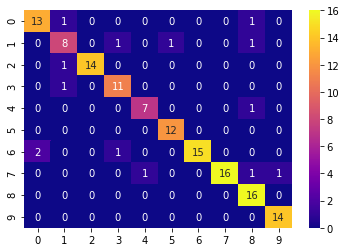

In [27]:
sns.heatmap(cm, cmap="plasma", annot=True)

#Accuracy Plots

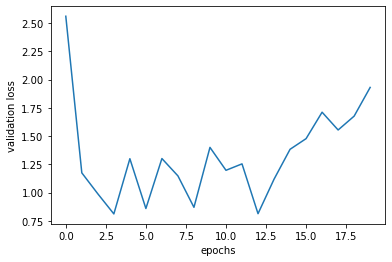

In [29]:
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

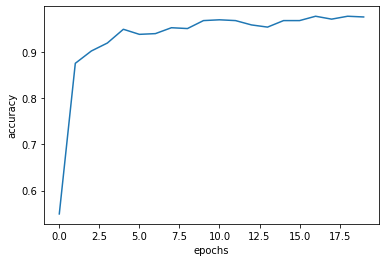

In [30]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

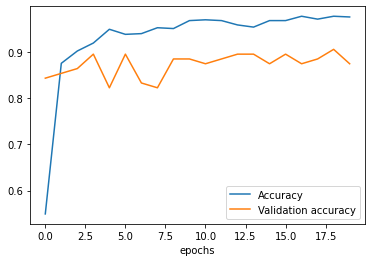

In [31]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

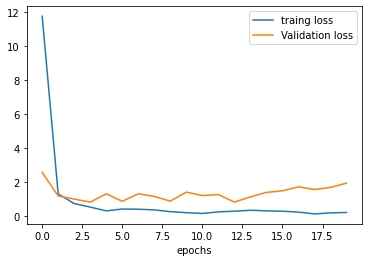

In [32]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

#F1-Score

In [33]:
from sklearn.metrics import f1_score

In [34]:
f1_score(test_set.classes, predictions, average=None)

array([0.86666667, 0.72727273, 0.96551724, 0.88      , 0.875     ,
       0.96      , 0.90909091, 0.91428571, 0.88888889, 0.96551724])

In [35]:
from sklearn.metrics import classification_report

In [38]:
print(classification_report(test_set.classes, predictions, target_names=list(test_set.class_indices.keys())))

                    precision    recall  f1-score   support

            beagle       0.87      0.87      0.87        15
         chihuahua       0.73      0.73      0.73        11
          doberman       1.00      0.93      0.97        15
    french_bulldog       0.85      0.92      0.88        12
  golden_retriever       0.88      0.88      0.88         8
          malamute       0.92      1.00      0.96        12
               pug       1.00      0.83      0.91        18
     saint_bernard       1.00      0.84      0.91        19
scottish_deerhound       0.80      1.00      0.89        16
   tibetan_mastiff       0.93      1.00      0.97        14

          accuracy                           0.90       140
         macro avg       0.90      0.90      0.90       140
      weighted avg       0.91      0.90      0.90       140



#ROC-AUC Curve

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve

In [45]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    other_class = [x for x in unique_class if x != per_class]

    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

In [48]:
lr_roc_auc_multiclass = roc_auc_score_multiclass(test_set.classes, predictions)
lr_roc_auc_multiclass

{0: 0.9253333333333333,
 1: 0.8520084566596194,
 2: 0.9666666666666667,
 3: 0.9505208333333333,
 4: 0.9337121212121212,
 5: 0.99609375,
 6: 0.9166666666666667,
 7: 0.9210526315789473,
 8: 0.9838709677419355,
 9: 0.996031746031746}